In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.interpolate import interp1d
from scipy.special import expit
from fractions import Fraction
from empiricaldist import Pmf, Cdf
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.formula.api as smfa

In [2]:
from data.utils import prob, update_machine, choose_play_update

In [3]:
k = 140
n = 250
like_fair = ss.binom(n, 0.5).pmf(k)
like_biased = ss.binom(n, 0.56).pmf(k)
K = like_biased / like_fair
K

6.075990838368468

<AxesSubplot:>

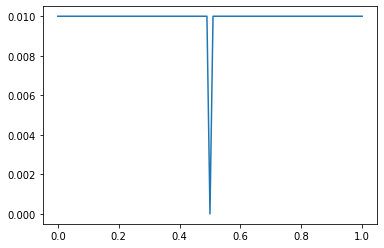

In [4]:
xs = np.linspace(0, 1, 101)
uniform = Pmf(1, xs)
biased_uniform = uniform.copy()
biased_uniform[0.5] = 0
biased_uniform.normalize()
biased_uniform.plot()

In [5]:
xs = biased_uniform.qs
likelihood = ss.binom(n, xs).pmf(k)
like_uniform = np.sum(biased_uniform * likelihood)
like_uniform

0.003900491927770735

In [6]:
K = like_uniform / like_fair
prior_odds = 1
posterior_odds = prior_odds * K
posterior_odds, prob(posterior_odds)

(0.4667233591607596, 0.3182081721448909)

In [7]:
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)
imsi = np.append(ramp_up, ramp_down)

<AxesSubplot:>

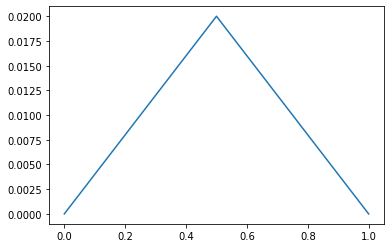

In [8]:
triangle = Pmf(imsi, xs)
triangle.normalize()
triangle.plot()

<AxesSubplot:>

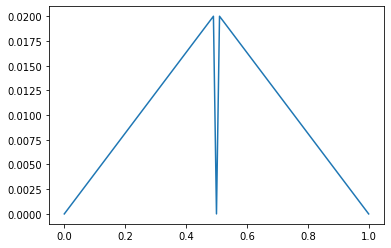

In [9]:
biased_triangle = triangle.copy()
biased_triangle[0.5] = 0
biased_triangle.normalize()
biased_triangle.plot()

In [10]:
xs = np.linspace(0, 1, 101)
prior = Pmf(1, xs)
prior.normalize()

101

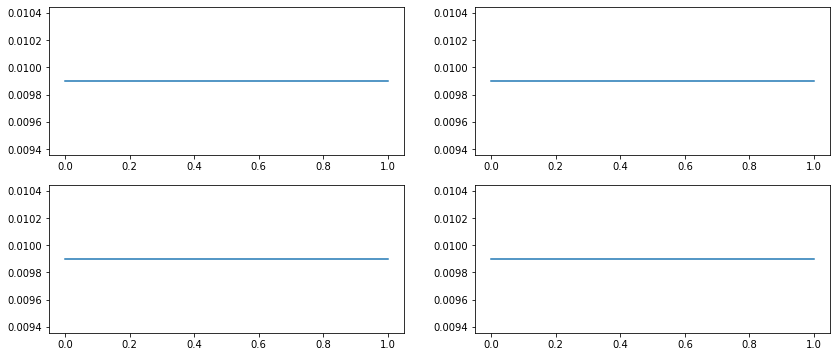

In [11]:
beliefs = [prior.copy() for i in range(4)]
fig, axs = plt.subplots(2, 2, figsize=(14, 6))
for belief, ax in zip(beliefs, axs.ravel()):
    belief.plot(ax=ax)

<AxesSubplot:>

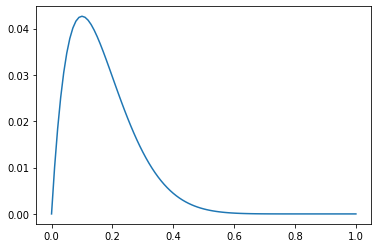

In [12]:
likelihood = {'W':xs, 'L':1 - xs}
bandit = prior.copy()
for outcome in 'WLLLLLLLLL':
    update_machine(bandit, likelihood, outcome)
bandit.plot()

In [13]:
actual_probs = [0.1, 0.2, 0.3, 0.4]
counter = Counter()
def play(i):
    counter[i] += 1
    p = actual_probs[i]
    if np.random.random() < p:
        return 'W'
    else:
        return 'L'
for i in range(4):
    for _ in range(100):
        outcome = play(i)
        update_machine(beliefs[i], likelihood, outcome)

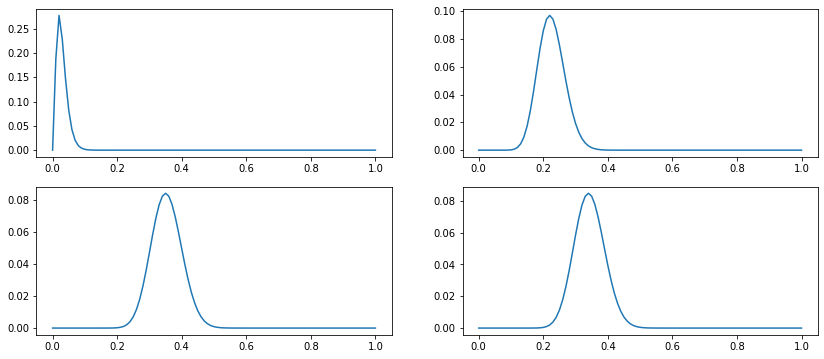

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(14, 6))
for belief, ax in zip(beliefs, axs.ravel()):
    belief.plot(ax=ax)

In [15]:
[belief.credible_interval(0.9) for belief in beliefs]

[array([0.01, 0.06]),
 array([0.16, 0.3 ]),
 array([0.28, 0.43]),
 array([0.27, 0.42])]

In [16]:
samples = np.array([b.choice(1000) for b in beliefs])
samples.shape

(4, 1000)

In [17]:
indices = np.argmax(samples, axis=0)
pmf = Pmf.from_seq(indices)
pmf

,probs
1,0.008
2,0.560
3,0.432


In [25]:
def choose_play_update(beliefs):
    def choose(beliefs):
        ps = [b.choice() for b in beliefs]
        return np.argmax(ps)
    machine = choose(beliefs)
    outcome = play(machine)
    update_machine(beliefs[machine], likelihood, outcome)

In [26]:
beliefs = [prior.copy() for i in range(4)]
likelihood = {'W':xs, 'L':1 - xs}
counter = Counter()

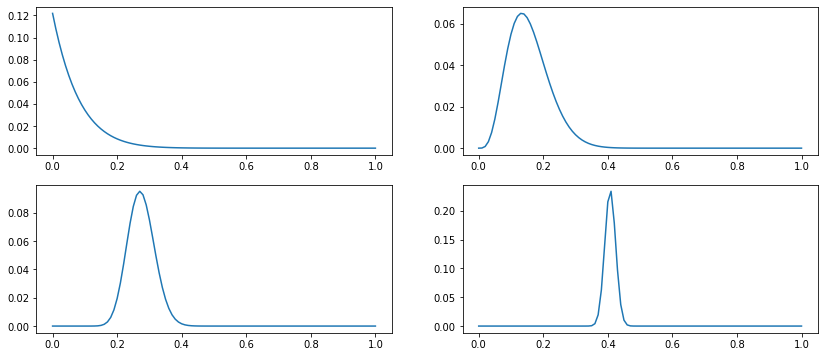

In [27]:
num_plays = 1000
for i in range(num_plays):
    choose_play_update(beliefs)
fig, axs = plt.subplots(2, 2, figsize=(14, 6))
for belief, ax in zip(beliefs, axs.ravel()):
    belief.plot(ax=ax)

In [34]:
interval = [{i:belief.credible_interval(0.9)} for i, belief in enumerate(beliefs)]
interval

[{0: array([0. , 0.2])},
 {1: array([0.07, 0.27])},
 {2: array([0.21, 0.35])},
 {3: array([0.38, 0.43])}]